<a href="https://colab.research.google.com/github/akhmad-ardi/Subject_Recommendation_System/blob/main/Subject_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistem Rekomendasi Mata Pelajaran

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
# from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
# Download dataset from kaggle
path = kagglehub.dataset_download("noorsaeed/student-studeis-recommendation")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/noorsaeed/student-studeis-recommendation/versions/1


## Exploratory Data Analysis

In [3]:
df = pd.read_csv(f"{path}/student-scores.csv")

df.head()

,id,first_name,last_name,email,gender,part_time_job,absence_days,extracurricular_activities,weekly_self_study_hours,career_aspiration,math_score,history_score,physics_score,chemistry_score,biology_score,english_score,geography_score
0,1,Paul,Casey,paul.casey.1@gslingacademy.com,male,False,3,False,27,Lawyer,73,81,93,97,63,80,87
1,2,Danielle,Sandoval,danielle.sandoval.2@gslingacademy.com,female,False,2,False,47,Doctor,90,86,96,100,90,88,90
2,3,Tina,Andrews,tina.andrews.3@gslingacademy.com,female,False,9,True,13,Government Officer,81,97,95,96,65,77,94
3,4,Tara,Clark,tara.clark.4@gslingacademy.com,female,False,5,False,3,Artist,71,74,88,80,89,63,86
4,5,Anthony,Campos,anthony.campos.5@gslingacademy.com,male,False,5,False,10,Unknown,84,77,65,65,80,74,76


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   id                          2000 non-null   int64 
 1   first_name                  2000 non-null   object
 2   last_name                   2000 non-null   object
 3   email                       2000 non-null   object
 4   gender                      2000 non-null   object
 5   part_time_job               2000 non-null   bool  
 6   absence_days                2000 non-null   int64 
 7   extracurricular_activities  2000 non-null   bool  
 8   weekly_self_study_hours     2000 non-null   int64 
 9   career_aspiration           2000 non-null   object
 10  math_score                  2000 non-null   int64 
 11  history_score               2000 non-null   int64 
 12  physics_score               2000 non-null   int64 
 13  chemistry_score             2000 non-null   int6

Variabel pada dataset:

1. id: ID unik untuk setiap siswa.
2. first_name: Nama depan siswa.
3. last_name: Nama belakang siswa.
4. email: Email siswa.
5. gender: Jenis kelamin siswa (male/female).
6. part_time_job: Menunjukkan apakah siswa memiliki pekerjaan paruh waktu (True/False).
7. absence_days: Jumlah hari siswa tidak hadir.
8. extracurricular_activities: Menunjukkan apakah siswa berpartisipasi dalam kegiatan ekstrakurikuler (True/False).
9. weekly_self_study_hours: Jumlah jam yang dihabiskan siswa untuk belajar mandiri per pekan.
10. career_aspiration: Jalur karier yang diharapkan dari siswa.
11. math_score: Skor yang dicapai siswa dalam matematika.
12. history_score:  Skor yang dicapai siswa dalam sejarah.
13. physics_score:  Skor yang dicapai siswa dalam fisika.
14. chemistry_score:  Skor yang dicapai siswa dalam kimia.
15. biology_score:  Skor yang dicapai siswa dalam biologi.
16. english_score:  Skor yang dicapai siswa dalam bahasa inggris.
17. geography_score:  Skor yang dicapai siswa dalam geografi.

In [5]:
df.describe()

,id,absence_days,weekly_self_study_hours,math_score,history_score,physics_score,chemistry_score,biology_score,english_score,geography_score
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000
mean,1000.500000,3.665500,17.755500,83.452000,80.332000,81.336500,79.995000,79.58150,81.277500,80.888000
std,577.494589,2.629271,12.129604,13.224906,12.736046,12.539453,12.777895,13.72219,12.027087,11.637705
min,1.000000,0.000000,0.000000,40.000000,50.000000,50.000000,50.000000,30.00000,50.000000,60.000000
25%,500.750000,2.000000,5.000000,77.000000,69.750000,71.000000,69.000000,69.00000,72.000000,71.000000
50%,1000.500000,3.000000,18.000000,87.000000,82.000000,83.000000,81.000000,81.00000,83.000000,81.000000
75%,1500.250000,5.000000,28.000000,93.000000,91.000000,92.000000,91.000000,91.00000,91.000000,91.000000
max,2000.000000,10.000000,50.000000,100.000000,100.000000,100.000000,100.000000,100.00000,99.000000,100.000000


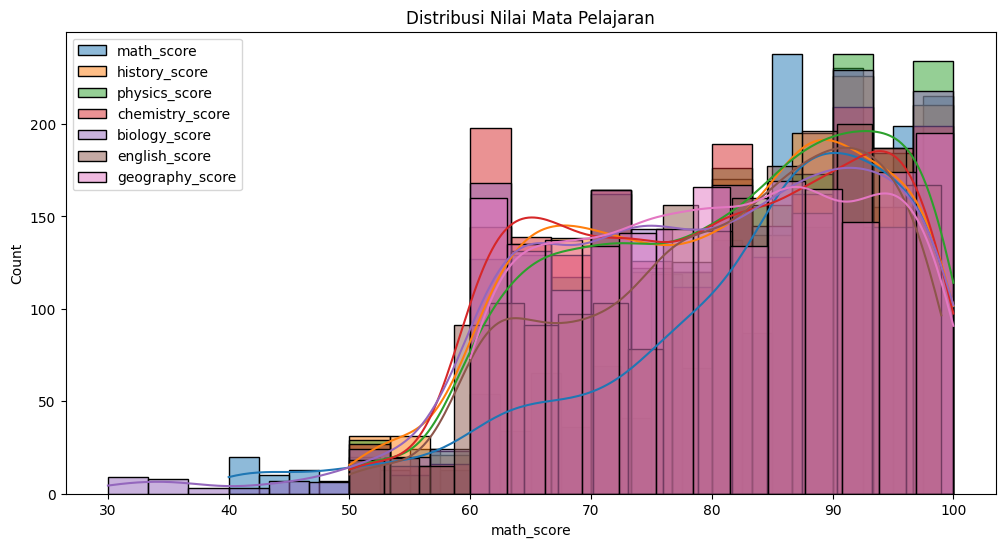

In [6]:
subjects = ['math_score', 'history_score', 'physics_score', 'chemistry_score', 'biology_score', 'english_score', 'geography_score']

plt.figure(figsize=(12, 6))
for subject in subjects:
    sns.histplot(df[subject], kde=True, label=subject, alpha=0.5)
plt.title("Distribusi Nilai Mata Pelajaran")
plt.legend()
plt.show()

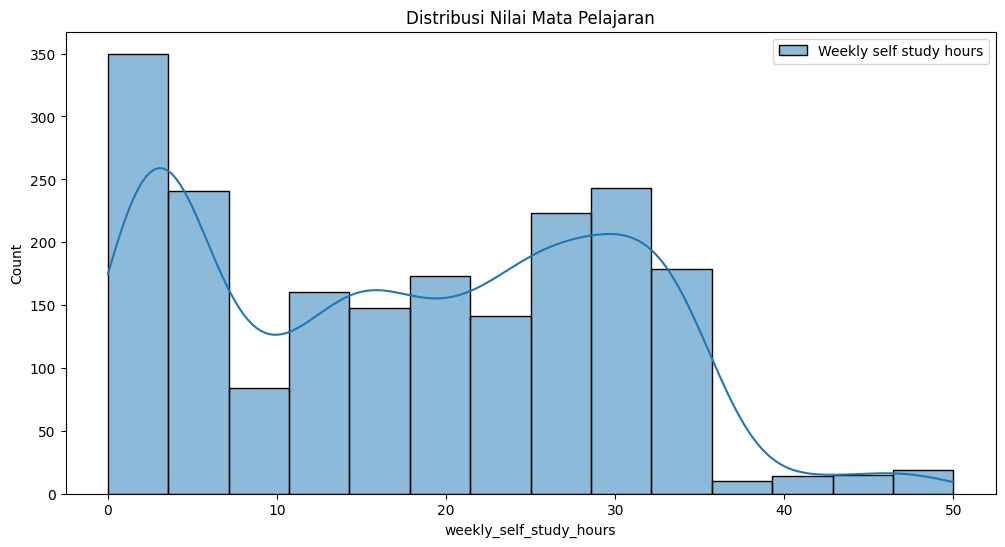

In [7]:
plt.figure(figsize=(12, 6))
sns.histplot(df['weekly_self_study_hours'], kde=True, label='Weekly self study hours', alpha=0.5)
plt.title("Distribusi Nilai Mata Pelajaran")
plt.legend()
plt.show()

## Data Preprocessing

### Miss Value

In [8]:
# Check missing values
print(df.isnull().sum())

id                            0
first_name                    0
last_name                     0
email                         0
gender                        0
part_time_job                 0
absence_days                  0
extracurricular_activities    0
weekly_self_study_hours       0
career_aspiration             0
math_score                    0
history_score                 0
physics_score                 0
chemistry_score               0
biology_score                 0
english_score                 0
geography_score               0
dtype: int64


Tidak ada miss value

## Data Preparation

In [9]:
features = subjects.copy() + ['career_aspiration']

features

['math_score',
 'history_score',
 'physics_score',
 'chemistry_score',
 'biology_score',
 'english_score',
 'geography_score',
 'career_aspiration']

### Train-Test-Split

In [10]:
train, test = train_test_split(df, test_size=0.1, shuffle=True, random_state=42)

train.shape, test.shape

((1800, 17), (200, 17))

### Normalisasi Nilai Mata Pelajaran

In [11]:
# Normalize scores
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(train[subjects].values)

In [12]:
pd.DataFrame(df_normalized, columns=subjects)

,math_score,history_score,physics_score,chemistry_score,biology_score,english_score,geography_score
0,0.783333,0.86,0.76,0.94,0.871429,0.775510,0.700
1,0.533333,0.82,0.36,0.58,0.971429,0.428571,0.725
2,1.000000,0.92,0.50,0.36,0.671429,0.959184,0.525
3,0.750000,0.28,0.98,0.86,0.842857,0.224490,0.175
4,0.066667,0.52,0.12,0.42,0.514286,0.081633,0.775
...,...,...,...,...,...,...,...
1795,0.800000,0.96,0.62,0.22,0.457143,0.938776,0.000
1796,0.733333,0.48,0.80,0.98,0.857143,0.857143,0.300
1797,1.000000,0.24,0.56,0.48,0.600000,0.469388,0.450
1798,0.516667,0.40,0.74,0.24,0.885714,0.265306,0.500


### TF-IDF Vektorisasi

In [13]:
# TF-IDF Vektorisasi 'career_aspiration'
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(train['career_aspiration'])

### Combined Features

In [14]:
subject_scores = train[subjects].values
combined_features = hstack([tfidf_matrix, subject_scores])

## Modeling

### Similarity Matrix

In [15]:
cosine_sim = cosine_similarity(df_normalized)

cosine_sim.shape

(1800, 1800)

### Recommendation Function

In [16]:
def recommend_subjects(input_scores, career_aspiration, top_n=3):
    # Normalisasi input nilai mata pelajaran
    input_scores = np.array(input_scores).reshape(1, -1)
    input_scores = scaler.transform(input_scores)  # Normalisasi menggunakan scaler yang sudah di-fit sebelumnya

    # Transformasi aspirasi karir menggunakan TF-IDF
    career_text = [career_aspiration]
    career_tfidf = tfidf.transform(career_text)

    # Gabungkan fitur input
    input_features = hstack([career_tfidf, input_scores])

    # Hitung similarity dengan semua siswa di dataset
    similarity_scores = cosine_similarity(input_features, combined_features)

    # Ambil indeks siswa dengan similarity tertinggi
    similar_students = np.argsort(similarity_scores[0])[::-1][1:top_n+1]  # Exclude diri sendiri

    # Rekomendasikan mata pelajaran dengan rata-rata nilai tertinggi dari siswa mirik
    recommended_subjects = train.iloc[similar_students][subjects].mean().sort_values(ascending=False).index.tolist()

    return recommended_subjects[:top_n]

## Evaluasi Model

In [17]:
def delete_prefix(string, prefix=""):
    return string.replace(prefix, "")

In [18]:
# Example subject grade input and career aspiration
math_score = 73
history_score = 81
physics_score = 85
chemistry_score = 70
biology_score = 63
english_score = 80
geography_score = 87
career_aspiration = "Software Engineer"

input_scores = [
    math_score,
    history_score,
    physics_score,
    chemistry_score,
    biology_score,
    english_score,
    geography_score
]  # Change as needed

recommendations = recommend_subjects(input_scores, career_aspiration, top_n=3)
print(f"Recommended subjects: {recommendations}")

recommended_mask_test = [1 if subject in recommendations else 0 for subject in features]

Recommended subjects: ['physics_score', 'history_score', 'english_score']


In [19]:
def evaluate_precision_at_k(k=3):
    precision_scores = []
    for i in range(len(test)):
        # Ambil nilai mata pelajaran dan aspirasi karir siswa ke-i
        student_scores = test.iloc[i][subjects].values
        career_aspiration = test.iloc[i]['career_aspiration']

        # Dapatkan rekomendasi
        recommended_subjects = recommend_subjects(student_scores, career_aspiration, top_n=k)

        # Ambil mata pelajaran dengan nilai tertinggi siswa (ground truth)
        true_subjects = test.iloc[i][subjects].sort_values(ascending=False).index.tolist()[:k]

        # Hitung precision
        overlap = len(set(true_subjects) & set(recommended_subjects))
        precision = overlap / k
        precision_scores.append(precision)

    return np.mean(precision_scores)

# Evaluasi dengan k=3
mean_precision = evaluate_precision_at_k(k=3)
print(f"Precision: {mean_precision * 100:.2f}%")

Precision@3: 85.50%
